In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import BertTokenizerFast, BertModel
from transformers import AdamW
from utils.datasets import TextDataset
from utils.lr_finder import run_lr_finder
from models.bert import BertForClassification

In [2]:
import tqdm.notebook as tqdm

In [3]:
MODEL = "neuralmind/bert-base-portuguese-cased"

# Loading tweet dataset

In [4]:
train_df = pd.read_csv("/home/kenzo/datasets/cleaned_tweetsentbr/train.tsv", sep="\t", names=["id", "label", "alfa", "text"], index_col=0)
test_df = pd.read_csv("/home/kenzo/datasets/cleaned_tweetsentbr/test.tsv", sep="\t", names=["id", "label", "alfa", "text"], index_col=0)

In [5]:
# TODO: Exploração dos dados

In [6]:
tokenizer = BertTokenizerFast.from_pretrained(MODEL)

In [7]:
train_ds = TextDataset.from_df(train_df, tokenizer, max_seq_len=128)
test_ds = TextDataset.from_df(test_df, tokenizer, max_seq_len=128)

# Preparing model

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from functools import partial

metrics = {
    "accuracy": accuracy_score,
    "precision": partial(precision_score, average="macro"),
    "recall": partial(recall_score, average="macro"),
    "f1": partial(f1_score, average="macro"),
}

In [9]:
gpu = torch.device("cuda:2")

In [10]:
bert_model = BertModel.from_pretrained(MODEL)

In [11]:
model = BertForClassification(bert_model, 3, metrics, device=gpu).cuda(gpu)

In [12]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

# Finding a good learning rate

In [13]:
batches = len(train_dl)
epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-7) 
# scheduler = OneCycleLR(optimizer, max_lr=5e-5, steps_per_epoch=batches, epochs=epochs)
criterion = nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.11E-05


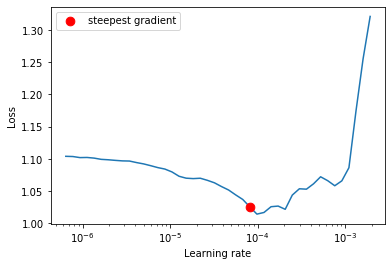

In [14]:
run_lr_finder(train_dl, model, optimizer, criterion, device=gpu)

In [15]:
scheduler = OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=batches, epochs=epochs)

In [16]:
train, test = model.fit(epochs, train_dl, test_dl, criterion, optimizer, scheduler=scheduler)


Epoch: 1
	train_loss: 0.8079968725706076 // test_loss: 0.7392450593985044// metrics: {'accuracy': 0.6835905767668562, 'precision': 0.6776241593584028, 'recall': 0.6397316867905434, 'f1': 0.647823967522863}




Epoch: 2
	train_loss: 0.5559200580630984 // test_loss: 0.6962152226613119// metrics: {'accuracy': 0.718927701056052, 'precision': 0.6970278890275766, 'recall': 0.6944954484477875, 'f1': 0.6941384854126981}




Epoch: 3
	train_loss: 0.20654526599622391 // test_loss: 0.823947243201427// metrics: {'accuracy': 0.723395613322502, 'precision': 0.7033815251086647, 'recall': 0.7009006816877865, 'f1': 0.7018698151405115}




In [17]:
torch.save(model.state_dict(), "data/checkpoints/bert_tweetsent_br.ckpt")